In [1]:
import sys
import os
sys.path.append(os.path.abspath('../utilities'))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

from lds_basics import (is_open_loop_stable, simulate)

# Setup and Initial Analysis

In [3]:
# DATA - adjust time to work well.
A = np.array([[1, 1, 0],
              [0, 1, 1],
              [0, 0, 1]])
B = np.array([[0, 0.5, 1]]).T
C = np.array([[-1, 0, 1]])
T = 100
n=3
m=1
p=1
U_max = 0.1
y_des = np.zeros((T+50, 1)) # add extra zeros for receeding horizon instances
y_des[29:69, :] = 10 #29-70 sets indices 29-68 to 10, corresponding to times t=30 to t = 69

In [4]:
is_open_loop_stable(A)

(False, array([1., 1., 1.]))

In [5]:
x_init = np.zeros((n, 1))
policy = np.zeros((m, T))
state_traj = simulate(A, B, 1, T, x_init, policy)

In [27]:
y_traj = np.array([C@state_traj[:, t] for t in range(1, T+1)])

In [28]:
y_traj.shape

(100, 1)

In [24]:
state_traj.shape

(3, 101)

In [40]:
state_traj.shape

(3, 101)

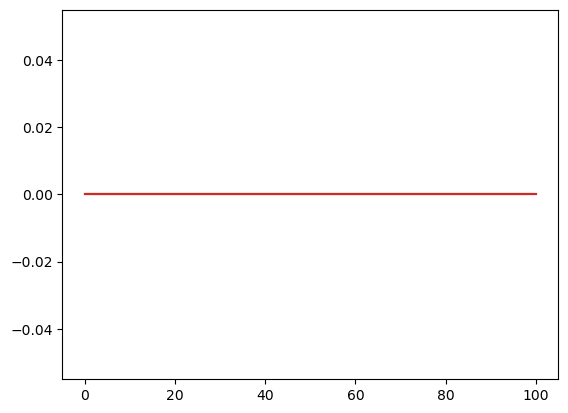

In [42]:
plt.plot(np.arange(T), y_traj.flatten())
for i in range(state_traj.shape[0]):
    plt.plot(np.arange(T+1), state_traj[i, :])

# Solving

## Optimal Output

We first solve the problem with access to the entire output trajectory

In [7]:
# makes notes of where you've had to do weird things to make this work
# makes notes of how you handle time
x = cp.Variable((n, T+1))
u = cp.Variable((m, T))

'''
(on website)
Q: Can I use NumPy functions on CVXPY objects?
A: No, you can only use CVXPY functions on CVXPY objects. If you use a NumPy function on a CVXPY object, it will probably fail in a confusing way.
'''
J_output = cp.sum_squares(cp.vstack([C@x[:, t] - y_des[t-1, :] for t in range(1, T+1)]))
obj = cp.Minimize(J_output)

constr = [x[:, 0]==np.zeros((n))]
for t in range(T):
    constr += [ x[:, t+1] == A@x[:, t] + B@u[:, t],
                cp.norm(u[:, t], 'inf') <= U_max]

prob = cp.Problem(obj, constr)
prob.solve()

112.41570012339267

## Model Predictive Control (Receeding Horizon) Implementation

We now abstract the previous solution code to a MPC approach.

In [30]:
def solve(T, t, x_init):
    x = cp.Variable((n, T+1))
    u = cp.Variable((m, T))

    J_output = cp.sum_squares(cp.vstack( [ C@x[:, tau] - y_des[tau + t - 1, :] 
                                          for tau in range(1, T+1) ] ))
    obj = cp.Minimize(J_output)

    constr = [x[:, 0] == x_init]
    for tau in range(T):
        constr += [ x[:, tau+1] == A@x[:, tau] + B@u[:, tau],
                   cp.norm(u[:, tau], 'inf') <= U_max ]
        
    prob = cp.Problem(obj, constr)
    prob.solve()
    return (prob.value, u.value, x.value)

In [48]:
def run_mpc(N, T):
    x = np.zeros((n))
    U_traj = np.zeros((m, T))
    Y = np.zeros((p, T))
    J_output = 0
    
    for t in range(T):
        _, u, _ = solve(N, t, x)
        U_traj[:, t] = u[:, 0]
        x = A@x + B@u[:, 0]
        y = C@x
        Y[:, t] = y
        J_output += cp.sum_squares(y - y_des[t, :]).value

    return (J_output, Y)


Test new solve function with full horizon (should have same solution as above).

In [49]:
sol, sol_u, sol_x = solve(100, 0, np.zeros((n))) # check with original
print(sol)

112.41570012339267


In [50]:
cost8, y_traj8 = run_mpc(8, 100)
print(cost8)

365.4625802081616


In [51]:
cost10, y_traj10 = run_mpc(10, 100)
print(cost10)

132.14290673333784


In [52]:
cost12, y_traj12 = run_mpc(12, 100)
print(cost12)

/Users/q3/opt/anaconda3/envs/boyd_linear-algebra/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


119.30470380069865


In [53]:
# create output trajectory associated with optimal solution
y_traj_opt = np.array([C@sol_x[:, t] for t in range(1, T+1)])

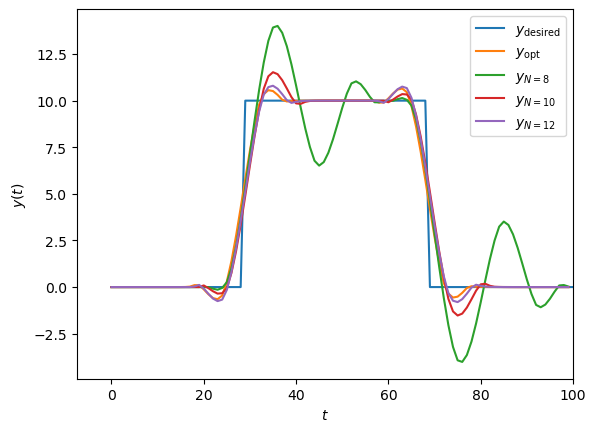

In [54]:
plt.plot(np.arange(len(y_des)), y_des, label="$y_{\\text{desired}}$")
plt.plot(np.arange(T), y_traj_opt.flatten(), label="$y_{\\text{opt}}$")
plt.plot(np.arange(T), y_traj8.flatten(), label="$y_{N=8}$")
plt.plot(np.arange(T), y_traj10.flatten(), label="$y_{N=10}$")
plt.plot(np.arange(T), y_traj12.flatten(), label="$y_{N=12}$")

plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.xlim(right=100)
# plt.title('Output Trajectories')
plt.legend()

plt.savefig('364b_mpc_output.pdf', bbox_inches='tight')

plt.show()